In [1]:
import numpy as np
import pandas as pd
import math
import torch
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [159]:
df = pd.read_csv('./EEG_Subject1.csv', header=None)
ydf = pd.read_csv('./Stimulus_Subject1.csv', header=None)
# sample frequency = 128 Hz
# samples per trail = 128 * 5 = 640
x = df.to_numpy()
y = ydf.to_numpy()[0]

In [160]:
x.shape, y.shape

((14, 187392), (187392,))

In [161]:
N = 641
f = 128

In [162]:
tmp = y[y!=0]
last = 0
for i in range(len(y)):
    if y[i] != y[i-1]:
        size = i-last
        print(size)
        last = i

1029
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1692
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1613
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1788
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1588
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
3865
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
2019
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1631
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1623
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1542
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
64

In [163]:
ydf.shape, 80125/641

((1, 187392), 125.0)

In [164]:
filtered_x = x[:,y!=0]
filtered_y = y[y!=0]
aggregate_y = []
for i in range(125):
    aggregate_y.append(filtered_y[i*641])
aggregate_y = np.array(aggregate_y)

trials = torch.from_numpy(x[:,y!=0]).unfold(1, 641, 641).permute((1,0,2)).numpy()

# Ploting trial

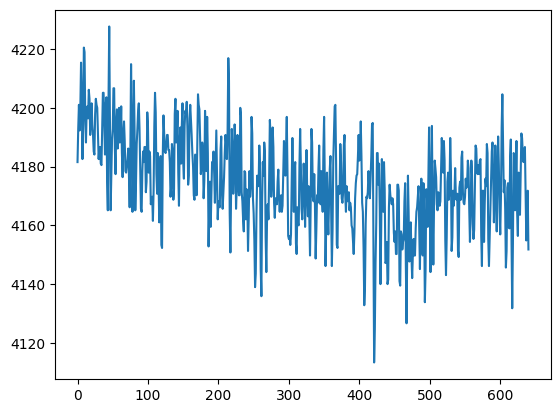

In [165]:
def plot_trial(data: np.ndarray):
    plt.plot(data);

trial = trials[0, 6]
plot_trial(trial)

# Normalize

In [166]:
def normalize(data: np.ndarray) -> np.ndarray:
    normal = data.copy()
    means = data.sum(axis=1)/data.shape[1]
    normal = (normal.transpose() - means).transpose()

    return normal

normal = normalize(x)
normal[:,:5]

array([[ 1.36989745e+01,  2.08829488e+01,  7.54487055e+00,
         1.26774769e+01,  2.65179311e+01],
       [-2.28858151e+01, -1.41699137e+01, -1.82715144e+01,
        -2.49445032e+01, -1.72461142e+01],
       [ 1.13254247e+01,  2.05550022e+01,  5.67870651e+00,
         6.19879898e+00,  2.10668393e+01],
       [-1.04190957e+02, -9.23981387e+01, -9.39418339e+01,
        -7.85554956e+01, -7.49619758e+01],
       [-5.28038771e+01, -6.71615104e+01, -5.22917042e+01,
        -4.51128875e+01, -5.28038771e+01],
       [ 3.02880969e+01,  4.36230626e+01,  2.00310979e+01,
         2.92649981e+01,  4.25999638e+01],
       [ 1.58367039e+01,  9.68710627e+00, -1.03183302e+01,
        -1.18578679e+01, -9.80515099e+00],
       [ 2.63616156e+01,  4.48179461e+01,  2.22573527e+01,
        -4.92160760e+00, -1.00540783e+01],
       [ 2.19524321e+00,  2.62926312e+01,  9.88314982e+00,
        -2.42396118e+00,  5.27202096e+00],
       [ 1.02996140e+01,  2.67096333e+01,  9.27561496e+00,
        -2.00573089e+00

# CAR

In [203]:
def car_filter(data: np.ndarray) -> np.ndarray:
    sum_signals = data.sum(axis=0) / data.shape[0]
    filtered_eeg_data = data.copy() - sum_signals
    return filtered_eeg_data

filtered_data = car_filter(normal)
filtered_data[:5]

array([[ 21.24447191,  20.8823545 ,  16.70339313, ...,  33.80951937,
         33.80951937,  33.80951937],
       [-15.3403177 , -14.17050805,  -9.11299181, ...,  51.58044854,
         51.58044854,  51.58044854],
       [ 18.87092219,  20.55440789,  14.83722908, ...,  43.74068728,
         43.74068728,  43.74068728],
       [-96.64545979, -92.39873307, -84.78331129, ...,  51.29935803,
         51.29935803,  51.29935803],
       [-45.25837966, -67.16210475, -43.13318164, ..., -90.64306516,
        -90.64306516, -90.64306516]])

In [228]:
trials_filtered = torch.from_numpy(filtered_data[:,y!=0]).unfold(1, 641, 641).permute((1,0,2)).numpy()

# DFT

In [229]:
def get_dft(data: np.ndarray) -> np.ndarray:
    res = np.absolute(np.fft.fft(data))
    return res

def plot_dft(data: np.ndarray, window=None) -> None:
    res = get_dft(data)
    if window == None:
        plt.plot(res);
    else:
        plt.plot(res[window])

def plot_components(components_val, components=[6.66,7.5,8.57,10,12], starting_index=0):
    components = [get_component_index(component) for component in components]
    # np_components = np.array(components) - starting_index
    plt.scatter(components, components_val, c="r")
    
# 12 -> 60,61
# 10 -> 50, 51
# 8.57 -> 42, 43
# 7.5 -> 37, 38
# 6.66 -> 33, 34

In [230]:
trials_dft = np.ndarray((125, 14, 641))
for trial in range(125):
    for electrode in range(14):
        trials_dft[trial, electrode] = get_dft(trials_filtered[trial, electrode])

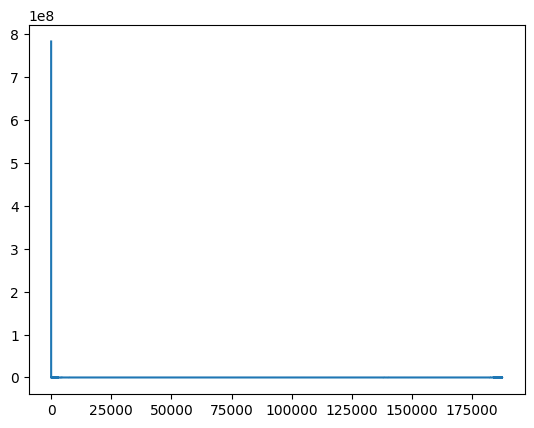

In [231]:
plot_dft(x[6])

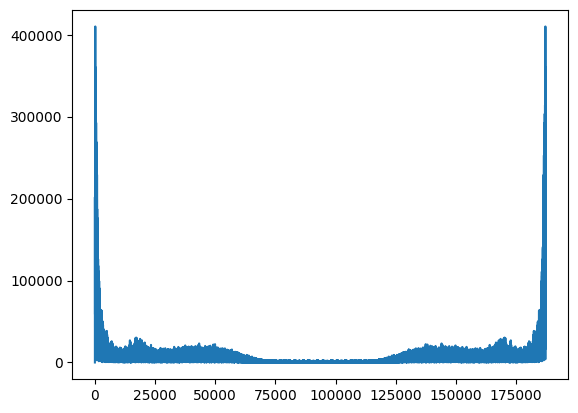

In [232]:
plot_dft(normalize(x)[6])

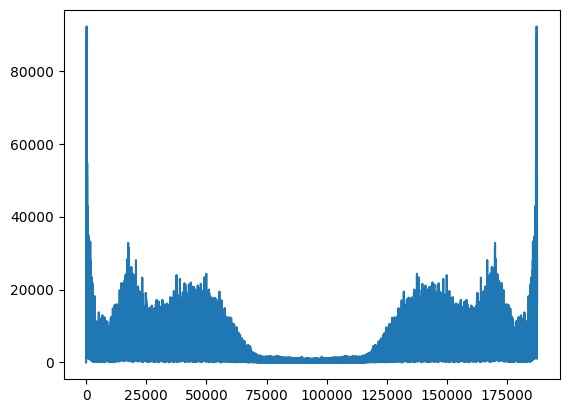

In [233]:
plot_dft(car_filter(normalize(x))[6])

In [234]:
trial_num = 0

(1, 2)

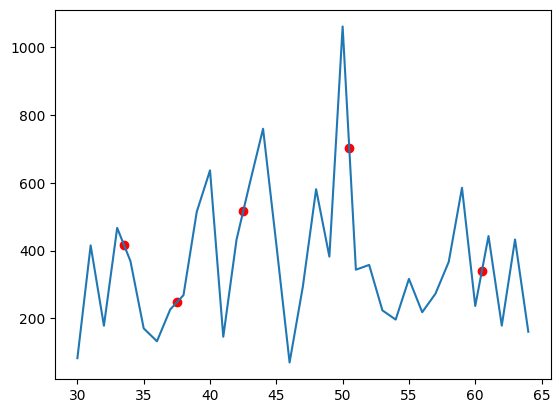

In [235]:
trial_num += 1

# plt.plot(trials_dft[trial_num, 7])
plt.plot(list(range(30,65)), trials_dft[trial_num, 7, 30:65])
# plot_dft(trials[trial_num, 7], slice(0, 65, 1))
plot_components(get_components_val_from_dft(trials_dft[trial_num,7]))
trial_num, aggregate_y[trial_num]

In [236]:
def get_component_index(freq, N=N, sampling_rate=f):
    freq_bins = np.fft.fftfreq(N, d=1/sampling_rate)
    for i in range(len(freq_bins)):
        if freq == freq_bins[i]:
            return i
        elif freq < freq_bins[i]:
            return i-.5

    raise Exception("Invalid frequency component")

def get_component(freq, freqs, N=N, sampling_rate=f):
    i = get_component_index(freq, N, sampling_rate)
    if (i%1 == 0):
        i = int(i)
        return freqs[i]
    else:
        i = int(i)
        return (freqs[i] + freqs[i+1]) / 2
    
def get_component_window(freq, freqs, freq_window_size=2, N=N, sampling_rate=f):
    i = get_component_index(freq, N, sampling_rate)
    i = int(i)
    return freqs[i-freq_window_size : i+freq_window_size+1]

get_component(12, trials_dft[0,6], 641)

# 12 -> 60,61
# 10 -> 50, 51
# 8.57 -> 42, 43
# 7.5 -> 37, 38
# 6.66 -> 33, 34

599.7622592328587

In [237]:
def get_components_val_from_dft(freqs, components=[6.66, 7.5, 8.57, 10, 12]):
    components_val = []
    for component in components:
        components_val.append(get_component(component, freqs))

    return components_val

def get_components_val(trial, components=[6.66, 7.5, 8.57, 10, 12]):
    freqs = get_dft(trial)
    return get_components_val_from_dft(freqs, components)

def get_components_val_from_dft_windowed(freqs, window_size=2, components=[6.66, 7.5, 8.57, 10, 12]):
    components_val = np.array([])
    for component in components:
        components_val = np.append(components_val, get_component_window(component, freqs, window_size))

    return components_val

def get_components_val_windowed(trial, window_size=2, components=[6.66, 7.5, 8.57, 10, 12]):
    freqs = get_dft(trial)
    return get_components_val_from_dft_windowed(freqs, window_size, components)

def get_highest_val(components_val):    
    return components_val.index(max(components_val))

def estimate_freq(trial, components=[12, 10, 8.57, 7.5, 6.66]):
    components_val = get_components_val(trial, components)
    return get_highest_val(components_val)

estimate_freq(trials_dft[0,6])

1

In [238]:
res_o1 = []
res_o2 = []
res_avg = []
for i in range(125):
    res_o1.append(estimate_freq(trials[i, 6])) # o1
    res_o2.append(estimate_freq(trials[i, 7])) # o2
    res_avg.append(estimate_freq((trials[i, 6] + trials[i, 7]) / 2)) # o2

res_o1 = np.array(res_o1)
res_o2 = np.array(res_o2)
res_avg = np.array(res_avg)
res_o1 += 1
res_o2 += 1
res_avg += 1
(res_o1 == aggregate_y).sum() / 125, (res_o2 == aggregate_y).sum() / 125, (res_avg == aggregate_y).sum() / 125

(0.528, 0.64, 0.64)

In [243]:
# narrow spectrum to only 5 components
trials_components = np.ndarray((125, 14, 5))
trials_components_window = np.ndarray((125, 14, 25))
for trial in range(125):
    for electrode in range(14):
        trials_components[trial, electrode] = get_components_val_from_dft(trials_dft[trial, electrode])
        # trials_components[trial, electrode] = trials_dft[trial, electrode, 30:65]
        trials_components_window[trial, electrode] = get_components_val_from_dft_windowed(trials_dft[trial, electrode])


In [244]:
# try using components only instead of all data
electrode = 7
for k in range(1,30):

    res = []
    for i in range(125):
        neigh = KNeighborsClassifier(n_neighbors=k)
        trials_sub = np.append(trials_components[:i], trials_components[i+1:], 0)

        y_sub = np.append(aggregate_y[:i], aggregate_y[i+1:])
        neigh.fit(trials_sub[:,electrode, :], y_sub)
        res.append(neigh.predict(trials_components[[i],electrode])[0])

    res = np.array(res)
    acc = (res == aggregate_y).sum() / 125
    print(f"{k}: {acc*100}")

1: 68.8
2: 69.6
3: 68.8
4: 69.6
5: 75.2
6: 73.6
7: 73.6
8: 74.4
9: 74.4
10: 77.60000000000001
11: 72.8
12: 74.4
13: 74.4
14: 79.2
15: 77.60000000000001
16: 77.60000000000001
17: 74.4
18: 75.2
19: 75.2
20: 76.8
21: 76.8
22: 76.0
23: 77.60000000000001
24: 76.8
25: 77.60000000000001
26: 76.8
27: 76.8
28: 78.4
29: 79.2
